In [2]:
import argparse
import os
import uuid
from IPython.core.magic import register_cell_magic
from IPython.display import SVG

@register_cell_magic
def plantuml(line, cell):
    """Generate and display a figure using Plantuml.
    Usage:
      %java -jar plantuml.jar -tsvg filname
    """

    parser = argparse.ArgumentParser()
    parser.add_argument("-n", "--name", type=str, default='puml_drawing',
                        help="<name>.svg and <name>.pdf after rendering")
    parser.add_argument("-t", "--tempname", type=str, default=None,
                        help="persist as <temp-name>.uml after rendering")
    parser.add_argument("-d", "--directory", default=None,
                        help="directory to save renders in")
    args = parser.parse_args(line.split() if line else "")

    retain = args.tempname is not None
    if args.directory :
        directory = args.directory + "/"
    else:
        directory = ""
    temp_name = args.tempname or str(uuid.uuid4())
    base_name = args.name

    uml_path = directory + base_name + ".uml"
    svg_path = directory + base_name + ".svg"
    pdf_path = directory + base_name + ".pdf"

    with open(uml_path, 'w') as fp:
        fp.write(cell)

    try:
        os.system("java -jar plantuml.jar -charset UTF-8 -tsvg %s" % uml_path)
        os.system("inkscape --file=%s --export-area-drawing --without-gui --export-pdf=%s" % (svg_path, pdf_path))
        return SVG(filename=svg_path)
    finally:
        if not retain:
            os.unlink(uml_path)

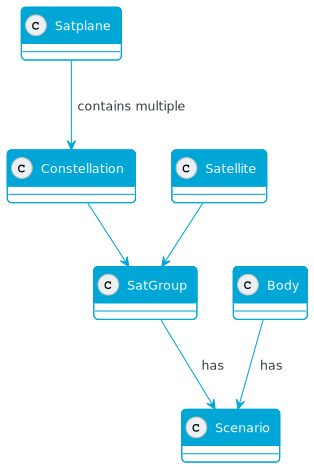

In [3]:
%%plantuml -t test -d D:/git/thesis_report_ae/figures

@startuml
!include D:\git\puml-themes\themes\tudelft\puml-theme-tudelft-outline.puml

class Scenario

class SatGroup

class Body

class Constellation

class Satellite

class Satplane

Satplane --> Constellation : contains multiple
Constellation --> SatGroup
Satellite --> SatGroup

SatGroup --> Scenario : has
Body --> Scenario : has

@enduml

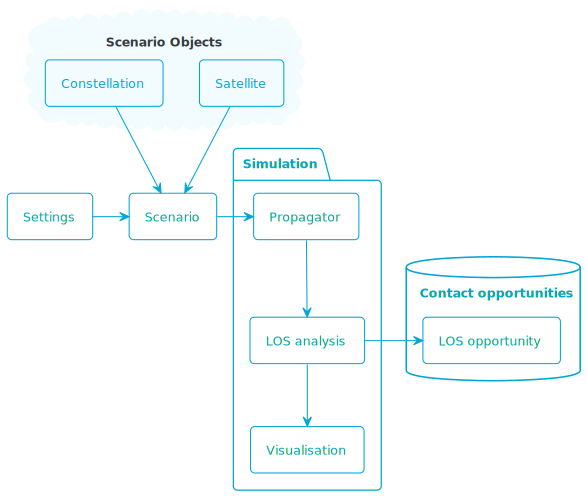

In [4]:
%%plantuml -n hermes_overview -d D:/git/thesis_report_ae/figures

@startuml
!include D:\git\puml-themes\themes\tudelft\puml-theme-tudelft-outline.puml

skinparam componentStyle rectangle


    package "Simulation" {
        [Propagator] -d-> [LOS analysis]
        [LOS analysis] -d-> [Visualisation]
    }

    [Scenario] -> [Propagator]
    [Settings] -r-> [Scenario]

    cloud "Scenario Objects" {
        [Satellite] --> [Scenario]
        [Constellation] --> [Scenario]
    }

    database "Contact opportunities" {
        [LOS opportunity]
    }
    [LOS analysis] -r-> [LOS opportunity]

@enduml

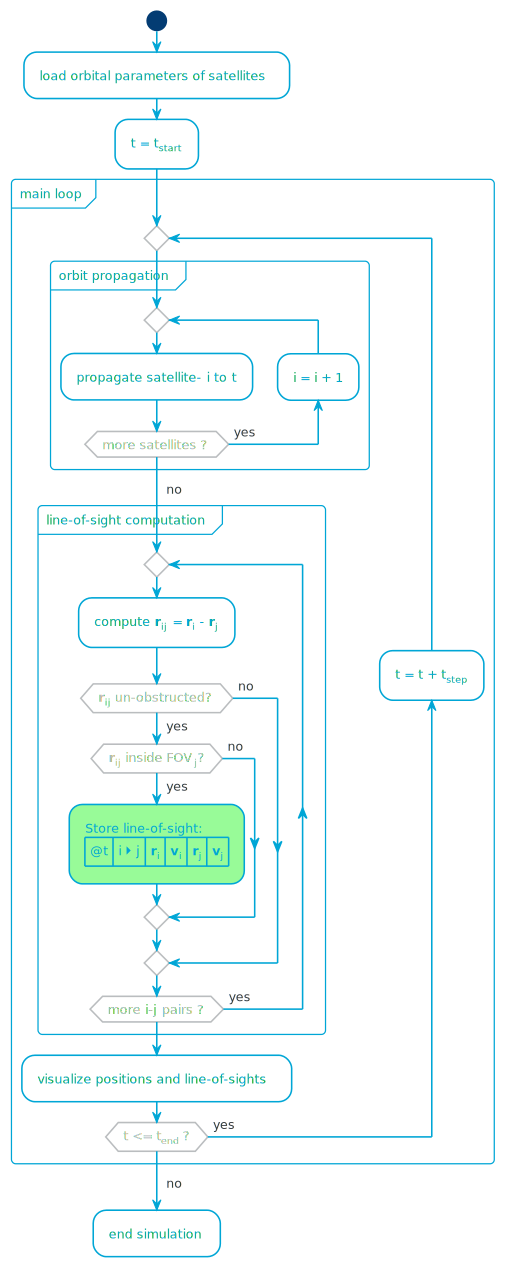

In [5]:
%%plantuml -n hermes_operation -d D:/git/thesis_report_ae/figures

@startuml
!include D:\git\puml-themes\themes\tudelft\puml-theme-tudelft-outline.puml
!pragma useVerticalIf on

start
:load orbital parameters of satellites;
://t = t<sub>start</sub>//;
partition "main loop" {
repeat
    partition "orbit propagation" {
        repeat
            :propagate satellite-//i// to //t//;
        backward://i = i + 1//;
        repeat while (more satellites ?) is (yes)
        -> no;
    }
    partition "line-of-sight computation" {
        repeat
            :compute //**r**<sub>ij</sub> = **r**<sub>i</sub> - **r**<sub>j</sub>//;
        if (**r**<sub>ij</sub> un-obstructed?) then (yes)
            if (**r**<sub>ij</sub> inside FOV<sub>j</sub>?) then (yes)
                #palegreen:Store line-of-sight:
                |@t|i <&caret-right>j|**r**<sub>i</sub>|**v**<sub>i</sub>|**r**<sub>j</sub>|**v**<sub>j</sub>|;
            else (no)
            endif
        else (no)
        endif


        repeat while (more //i-j// pairs ?) is (yes)
    }

:visualize positions and line-of-sights;
backward://t = t + t<sub>step</sub>//;
repeat while (//t <= t<sub>end</sub>// ?) is (yes)


}
-> no;
:end simulation;
@enduml


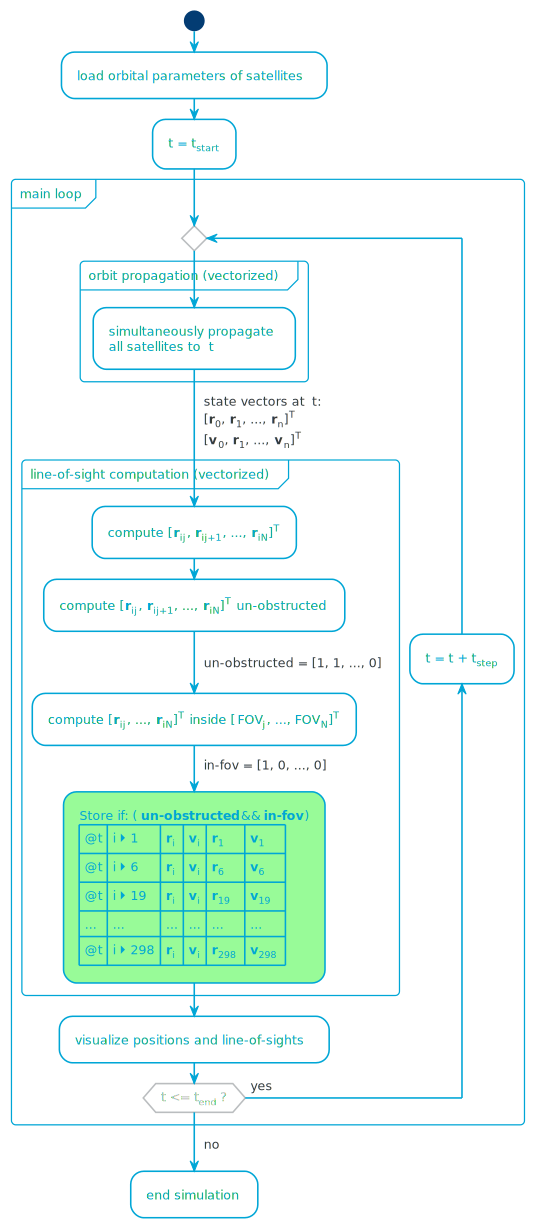

In [6]:
%%plantuml -n hermes_operation_vectorized -d D:/git/thesis_report_ae/figures

@startuml
!include D:\git\puml-themes\themes\tudelft\puml-theme-tudelft-outline.puml
!pragma useVerticalIf on

start
:load orbital parameters of satellites;
://t = t<sub>start</sub>//;
partition "main loop" {
repeat
    partition "orbit propagation (vectorized)" {
        :simultaneously propagate\nall satellites to //t//;
    }
    -> state vectors at //t//:
    [//**r**<sub>0</sub>, **r**<sub>1</sub>, ..., **r**<sub>n</sub>//]<sup>T</sup>
    [//**v**<sub>0</sub>, **r**<sub>1</sub>, ..., **v**<sub>n</sub>//]<sup>T</sup>;

    partition "line-of-sight computation (vectorized)" {
        :compute [//**r**<sub>ij</sub>, **r**<sub>ij+1</sub>, ..., **r**<sub>iN</sub>//]<sup>T</sup>;
        :compute [//**r**<sub>ij</sub>, **r**<sub>ij+1</sub>, ..., **r**<sub>iN</sub>//]<sup>T</sup> un-obstructed;
        -> un-obstructed = [1, 1, ..., 0];
        :compute [//**r**<sub>ij</sub>, ..., **r**<sub>iN</sub>//]<sup>T</sup> inside [//FOV<sub>j</sub>, ..., FOV<sub>N</sub>//]<sup>T</sup>;
        -> in-fov = [1, 0, ..., 0];
        #palegreen:Store if: (**un-obstructed** && **in-fov**)
        |@t|i <&caret-right>1|**r**<sub>i</sub>|**v**<sub>i</sub>|**r**<sub>1</sub>|**v**<sub>1</sub>|
        |@t|i <&caret-right>6|**r**<sub>i</sub>|**v**<sub>i</sub>|**r**<sub>6</sub>|**v**<sub>6</sub>|
        |@t|i <&caret-right>19|**r**<sub>i</sub>|**v**<sub>i</sub>|**r**<sub>19</sub>|**v**<sub>19</sub>|
        |...|...|...|...|...|...|
        |@t|i <&caret-right>298|**r**<sub>i</sub>|**v**<sub>i</sub>|**r**<sub>298</sub>|**v**<sub>298</sub>|;
    }

:visualize positions and line-of-sights;
backward://t = t + t<sub>step</sub>//;
repeat while (//t <= t<sub>end</sub>// ?) is (yes)


}
-> no;
:end simulation;
@enduml


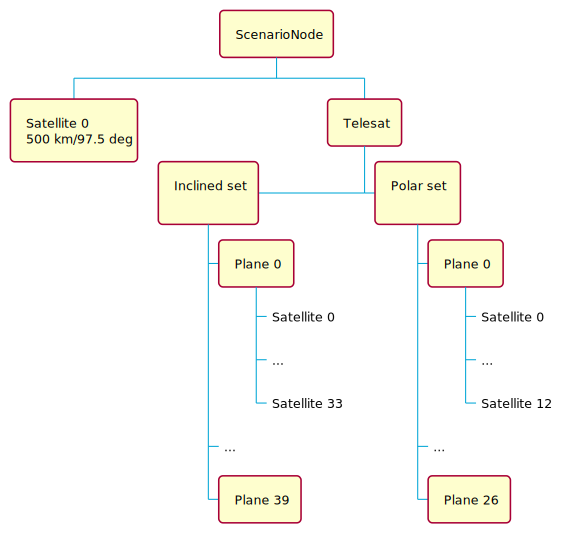

In [7]:
%%plantuml -n hermes_tree_structure_telesat -d D:/git/thesis_report_ae/figures

@startwbs

!include D:\git\puml-themes\themes\tudelft\puml-theme-tudelft-outline.puml
+ ScenarioNode
++ Satellite 0 \n500 km/97.5 deg
++ Telesat
--- Inclined set \n
++++ Plane 0
+++++_ Satellite 0
+++++_ ...
+++++_ Satellite 33
'++++ Plane 1
++++_ ...
++++ Plane 39

+++ Polar set \n
++++ Plane 0
+++++_ Satellite 0
+++++_ ...
+++++_ Satellite 12
'++++ Plane 1
++++_ ...
++++ Plane 26

@endwbs

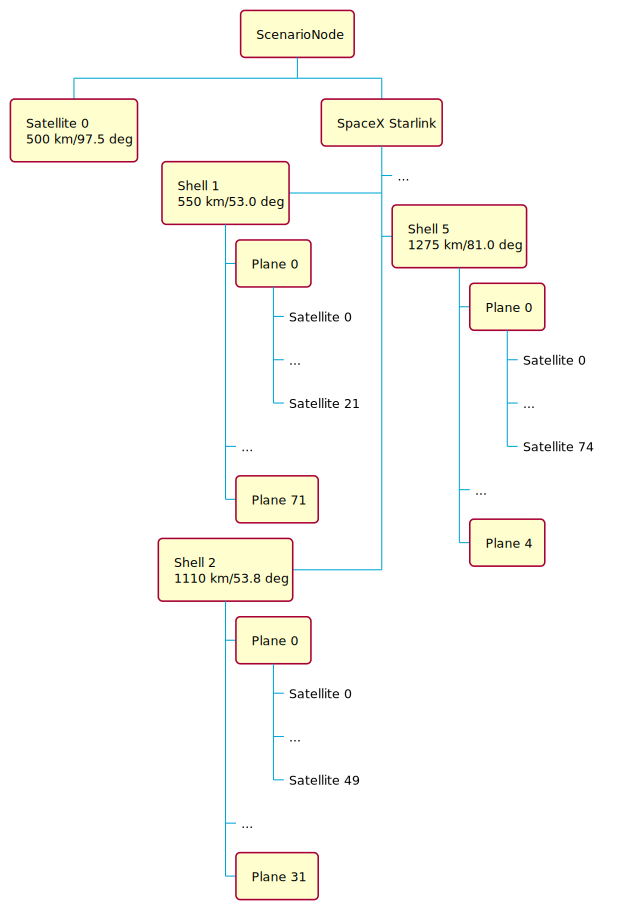

In [8]:
%%plantuml -n hermes_tree_structure_spacex -d D:/git/thesis_report_ae/figures

@startwbs

!include D:\git\puml-themes\themes\tudelft\puml-theme-tudelft-outline.puml
+ ScenarioNode
++ Satellite 0 \n500 km/97.5 deg
++ SpaceX Starlink
--- Shell 1\n550 km/53.0 deg
++++ Plane 0
+++++_ Satellite 0
+++++_ ...
+++++_ Satellite 21
'++++ Plane 1
++++_ ...
++++ Plane 71

--- Shell 2\n1110 km/53.8 deg
++++ Plane 0
+++++_ Satellite 0
+++++_ ...
+++++_ Satellite 49
'++++ Plane 1
++++_ ...
++++ Plane 31

+++_ ...

+++ Shell 5\n1275 km/81.0 deg
++++ Plane 0
+++++_ Satellite 0
+++++_ ...
+++++_ Satellite 74
'++++ Plane 1
++++_ ...
++++ Plane 4

@endwbs

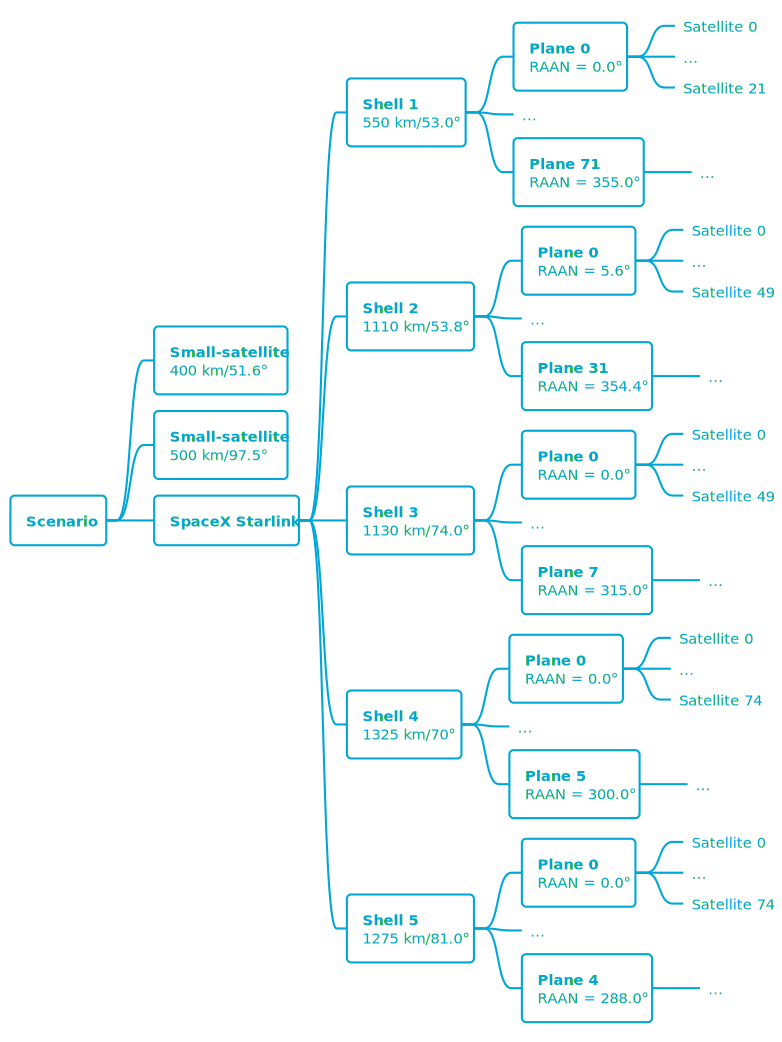

In [9]:
%%plantuml -n hermes_tree_structure_spacex -d D:/git/thesis_report_ae/figures

@startmindmap

!include D:\git\puml-themes\themes\tudelft\puml-theme-tudelft-outline.puml

<style>
mindmapDiagram {
  'Padding 8
  Margin 8
  LineThickness 2.0
  FontColor $PRIMARY_TEXT
  LineColor $PRIMARY
  BackGroundColor $BGCOLOR
}
</style>

* <b>Scenario</b>

** <b>Small-satellite</b>\n400 km/51.6°
** <b>Small-satellite</b>\n500 km/97.5°

** <b>SpaceX Starlink</b>
*** <b>Shell 1</b>\n550 km/53.0°
**** <b>Plane 0</b>\nRAAN = 0.0°
*****_ Satellite 0
*****_ ...
*****_ Satellite 21
'**** Plane 1
****_ ...
**** <b>Plane 71</b>\nRAAN = 355.0°
*****_ ...

*** <b>Shell 2</b>\n1110 km/53.8°
**** <b>Plane 0</b>\nRAAN = 5.6°
*****_ Satellite 0
*****_ ...
*****_ Satellite 49
'**** Plane 1
****_ ...
**** <b>Plane 31</b>\nRAAN = 354.4°
*****_ ...

*** <b>Shell 3</b>\n1130 km/74.0°
**** <b>Plane 0</b>\nRAAN = 0.0°
*****_ Satellite 0
*****_ ...
*****_ Satellite 49
'**** Plane 1
****_ ...
**** <b>Plane 7</b>\nRAAN = 315.0°
*****_ ...

*** <b>Shell 4</b>\n1325 km/70°
**** <b>Plane 0</b>\nRAAN = 0.0°
*****_ Satellite 0
*****_ ...
*****_ Satellite 74
'**** Plane 1
****_ ...
**** <b>Plane 5</b>\nRAAN = 300.0°
*****_ ...

*** <b>Shell 5</b>\n1275 km/81.0°
**** <b>Plane 0</b>\nRAAN = 0.0°
*****_ Satellite 0
*****_ ...
*****_ Satellite 74
'**** Plane 1
****_ ...
**** <b>Plane 4</b>\nRAAN = 288.0°
*****_ ...

@endmindmap

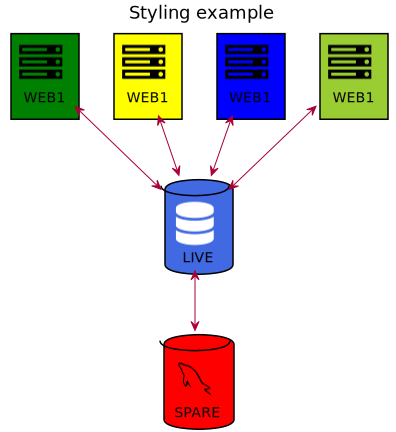

In [11]:
%%plantuml -n test -d D:/git/thesis_report_ae/figures

@startuml

skinparam defaultTextAlignment center

!define ICONURL https://raw.githubusercontent.com/tupadr3/plantuml-icon-font-sprites/v2.2.0

!includeurl ICONURL/common.puml
!includeurl ICONURL/devicons/mysql.puml
!includeurl ICONURL/font-awesome/server.puml
!includeurl ICONURL/font-awesome-5/database.puml

title Styling example

FA_SERVER(web1,WEB1) #Green
FA_SERVER(web2,WEB1) #Yellow
FA_SERVER(web3,WEB1) #Blue
FA_SERVER(web4,WEB1) #YellowGreen

FA5_DATABASE(db1,LIVE,database,white) #RoyalBlue
DEV_MYSQL(db2,SPARE,database) #Red

db1 <--> db2

web1 <--> db1
web2 <--> db1
web3 <--> db1
web4 <--> db1

@enduml

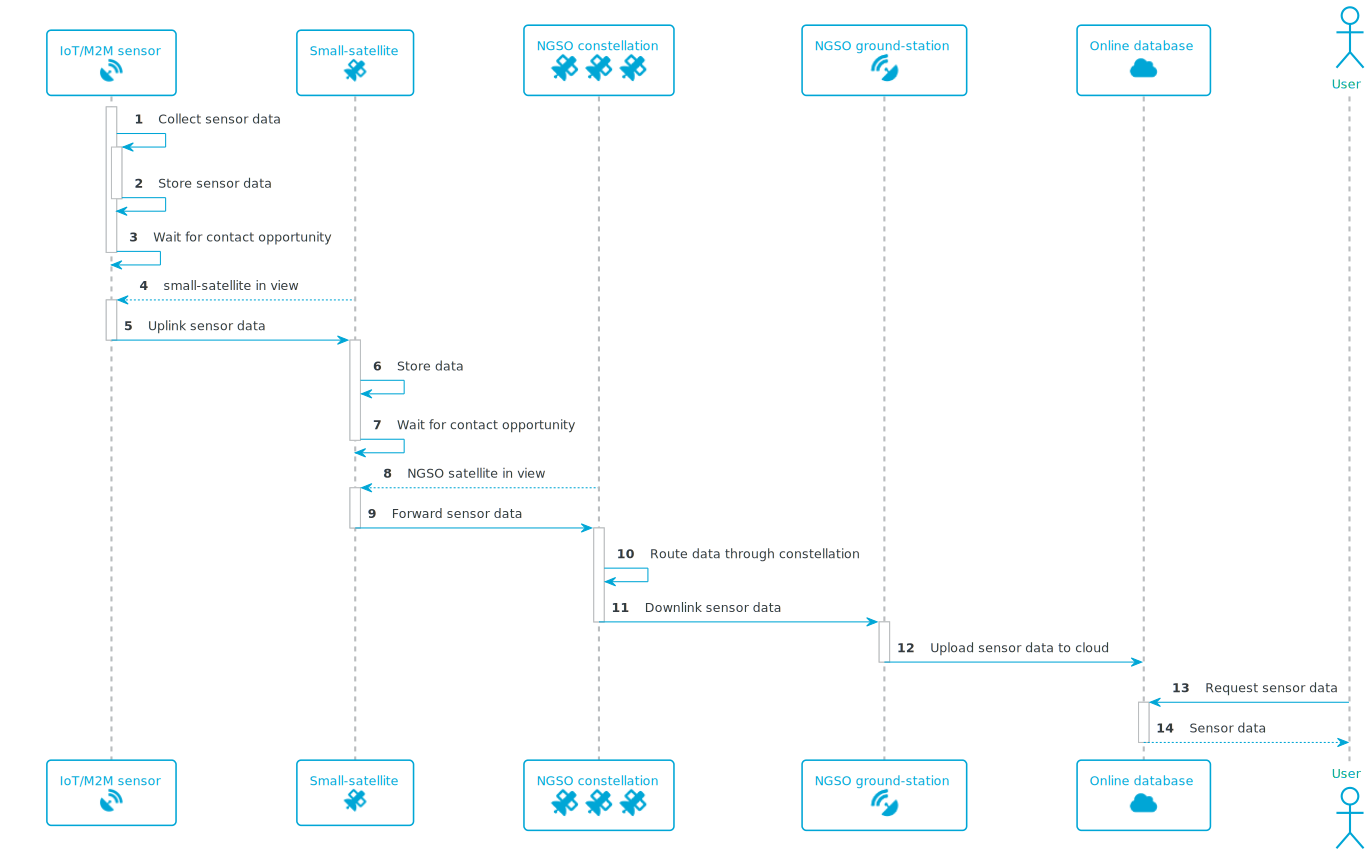

In [77]:
%%plantuml -n IoTM2MSequence -d D:/git/thesis_report_ae/figures

@startuml

sprite $satellite_dish_rev [48x48/16] {
000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000
00000000000000000000000258ACC3000000000000000000
0000000000000000000049EFFFFFF9000000000000000000
0000000000000000007DFFFFFFFFFA000000000000000000
00000000000000007EFFFFFFFFFFFA000000000000000000
000000000000003DFFFFFFFFFFFFF8000000000000000000
00000000000007FFFFFFFFFFFEB970000000000000000000
000000000000BFFFFFFFFFB6100000000000000000000000
00000000001CFFFFFFFF8100000000000000000000000000
0000000001DFFFFFFF910000158AA2000000000000000000
000000000CFFFFFFE300006CFFFFF9000000000000000000
000000009FFFFFFC10005EFFFFFFFA000000000000000000
00000005FFFFFFB0002CFFFFFFFFFA000000000000000000
0000001FFFFFFB0004FFFFFFFFFFF9000000000000000000
000000AFFFFFD0007FFFFFFFFFFDA1000000000000000000
000003FFFFFF2006FFFFFFFFA40000000000000000000000
00000BFFFFF7004FFFFFFFA1000000000000000000000000
00002FFFFFD001EFFFFFF500000000000000000000000000
00009FFFFF4009FFFFFF3000000000000000000004C60000
0000FFFFFD002FFFFFF4000000000000000000004FFF1000
0004FFFFF600AFFFFF8000000000000000000004FFFF8000
0008FFFFF101FFFFFD000000000000000000004FFFFFE000
000CFFFFC006FFFFF500000000210000000004FFFFFFF300
000FFFFF800BFFFFF00000000CFFA00000004FFFFFFFF700
002FFFFF500EFFFFA00000008FFFF6000004FFFFFFFFFA00
003FFFFF301FFFFF60000000BFFFF900004FFFFFFFFFFB00
005FFFFF103FFFFF300000008FFFFC1004FFFFFFFFFFFD00
002FFFFC001EFFFD000000000BFFFFC14FFFFFFFFFFFFC00
0000222000002220000000000012DFFDFFFFFFFFFFFFFB00
00000000000000000000000000001DFFFFFFFFFFFFFFFA00
000000000000000000000000000005FFFFFFFFFFFFFFF700
00000000000000000000000000004FFFFFFFFFFFFFFFF300
0000000000000000000000000004FFFFFFFFFFFFFFFFE000
000000000000000000000000004FFFFFFFFFFFFFFFFF8000
00000000000000000000000004FFFFFFFFFFFFFFFFFF2000
0000000000000000000000004FFFFFFFFFFFFFFFFFF90000
000000000000000000000004FFFFFFFFFFFFFFFFFFE10000
00000000000000000000004FFFFFFFFFFFFFFFFFFF400000
0000000000000000000004FFFFFFFFFFFFFFFFFFF7000000
000000000000000000004FFFFFFFFFFFFFFFFFFF80000000
00000000000000000002FFFFFFFFFFFFFFFFFFF500000000
00000000000000000003FFFFFFFFFFFFFFFFFC3000000000
000000000000000000005CFFFFFFFFFFFFFD600000000000
000000000000000000000039DFFFFFFFD930000000000000
000000000000000000000000012454310000000000000000
000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000
}

skinparam defaultTextAlignment center

!include D:\git\puml-themes\themes\tudelft\puml-theme-tudelft-outline.puml
!define ICONURL https://raw.githubusercontent.com/tupadr3/plantuml-icon-font-sprites/v2.2.0

!includeurl ICONURL/font-awesome-5/satellite.puml
!includeurl ICONURL/font-awesome-5/satellite_dish.puml
!includeurl ICONURL/font-awesome-5/cloud.puml

!define _dockerbackgroundcolor #7B1FA2
!define _dockercolor #CE93D8
!define _dockercoloralternate #F48FB1
!define _dockertextcolor #FFFFFF

!define _scale 0.5

autonumber
participant "IoT/M2M sensor\n<$satellite_dish{scale=_scale}>" as iot
participant "Small-satellite\n<$satellite{scale=_scale}>" as sc
participant "NGSO constellation\n<$satellite{scale=0.6}> <$satellite{scale=0.6}> <$satellite{scale=0.6}>" as dr
participant "NGSO ground-station\n<$satellite_dish_rev{scale=0.6}>" as gs
participant "Online database\n<$cloud{scale=0.6}>" as cloud

actor User

activate iot
iot -> iot++: Collect sensor data
iot -> iot--: Store sensor data
iot -> iot--: Wait for contact opportunity
sc --> iot++: //small-satellite in view//
iot -> sc--: Uplink sensor data
activate sc
sc -> sc: Store data
sc -> sc--: Wait for contact opportunity
dr --> sc++: //NGSO satellite in view//
sc -> dr--: Forward sensor data
activate dr
dr -> dr: Route data through constellation
dr -> gs--: Downlink sensor data
activate gs
gs -> cloud--: Upload sensor data to cloud
User -> cloud++: Request sensor data
return Sensor data

@enduml

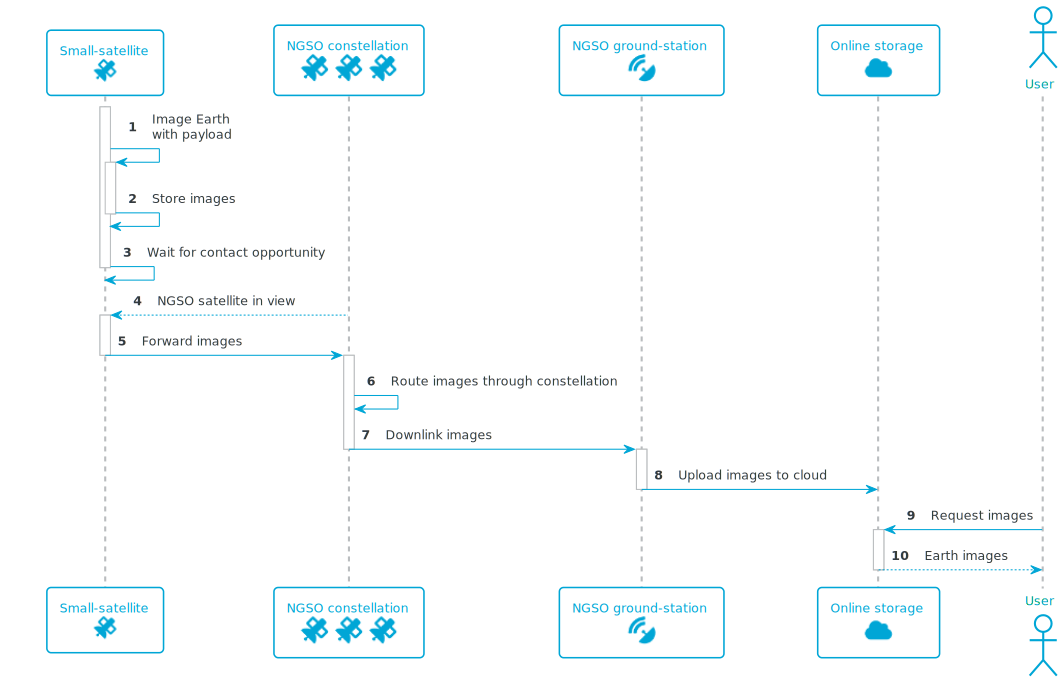

In [76]:
%%plantuml -n EOSequence -d D:/git/thesis_report_ae/figures

@startuml

sprite $satellite_dish_rev [48x48/16] {
000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000
00000000000000000000000258ACC3000000000000000000
0000000000000000000049EFFFFFF9000000000000000000
0000000000000000007DFFFFFFFFFA000000000000000000
00000000000000007EFFFFFFFFFFFA000000000000000000
000000000000003DFFFFFFFFFFFFF8000000000000000000
00000000000007FFFFFFFFFFFEB970000000000000000000
000000000000BFFFFFFFFFB6100000000000000000000000
00000000001CFFFFFFFF8100000000000000000000000000
0000000001DFFFFFFF910000158AA2000000000000000000
000000000CFFFFFFE300006CFFFFF9000000000000000000
000000009FFFFFFC10005EFFFFFFFA000000000000000000
00000005FFFFFFB0002CFFFFFFFFFA000000000000000000
0000001FFFFFFB0004FFFFFFFFFFF9000000000000000000
000000AFFFFFD0007FFFFFFFFFFDA1000000000000000000
000003FFFFFF2006FFFFFFFFA40000000000000000000000
00000BFFFFF7004FFFFFFFA1000000000000000000000000
00002FFFFFD001EFFFFFF500000000000000000000000000
00009FFFFF4009FFFFFF3000000000000000000004C60000
0000FFFFFD002FFFFFF4000000000000000000004FFF1000
0004FFFFF600AFFFFF8000000000000000000004FFFF8000
0008FFFFF101FFFFFD000000000000000000004FFFFFE000
000CFFFFC006FFFFF500000000210000000004FFFFFFF300
000FFFFF800BFFFFF00000000CFFA00000004FFFFFFFF700
002FFFFF500EFFFFA00000008FFFF6000004FFFFFFFFFA00
003FFFFF301FFFFF60000000BFFFF900004FFFFFFFFFFB00
005FFFFF103FFFFF300000008FFFFC1004FFFFFFFFFFFD00
002FFFFC001EFFFD000000000BFFFFC14FFFFFFFFFFFFC00
0000222000002220000000000012DFFDFFFFFFFFFFFFFB00
00000000000000000000000000001DFFFFFFFFFFFFFFFA00
000000000000000000000000000005FFFFFFFFFFFFFFF700
00000000000000000000000000004FFFFFFFFFFFFFFFF300
0000000000000000000000000004FFFFFFFFFFFFFFFFE000
000000000000000000000000004FFFFFFFFFFFFFFFFF8000
00000000000000000000000004FFFFFFFFFFFFFFFFFF2000
0000000000000000000000004FFFFFFFFFFFFFFFFFF90000
000000000000000000000004FFFFFFFFFFFFFFFFFFE10000
00000000000000000000004FFFFFFFFFFFFFFFFFFF400000
0000000000000000000004FFFFFFFFFFFFFFFFFFF7000000
000000000000000000004FFFFFFFFFFFFFFFFFFF80000000
00000000000000000002FFFFFFFFFFFFFFFFFFF500000000
00000000000000000003FFFFFFFFFFFFFFFFFC3000000000
000000000000000000005CFFFFFFFFFFFFFD600000000000
000000000000000000000039DFFFFFFFD930000000000000
000000000000000000000000012454310000000000000000
000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000
}

skinparam defaultTextAlignment center

!include D:\git\puml-themes\themes\tudelft\puml-theme-tudelft-outline.puml
!define ICONURL https://raw.githubusercontent.com/tupadr3/plantuml-icon-font-sprites/v2.2.0

!includeurl ICONURL/font-awesome-5/satellite.puml
!includeurl ICONURL/font-awesome-5/satellite_dish.puml
!includeurl ICONURL/font-awesome-5/cloud.puml

!define _dockerbackgroundcolor #7B1FA2
!define _dockercolor #CE93D8
!define _dockercoloralternate #F48FB1
!define _dockertextcolor #FFFFFF

!define _scale 0.5

autonumber
participant "Small-satellite\n<$satellite{scale=_scale}>" as sc
participant "NGSO constellation\n<$satellite{scale=0.6}> <$satellite{scale=0.6}> <$satellite{scale=0.6}>" as dr
participant "NGSO ground-station\n<$satellite_dish_rev{scale=0.6}>" as gs
participant "Online storage\n<$cloud{scale=0.6}>" as cloud

actor User
activate sc
sc -> sc++ : Image Earth\nwith payload
sc -> sc-- : Store images
sc -> sc--: Wait for contact opportunity
dr --> sc++: //NGSO satellite in view//
sc -> dr--: Forward images
activate dr
dr -> dr: Route images through constellation
dr -> gs--: Downlink images
activate gs
gs -> cloud--: Upload images to cloud
User -> cloud++: Request images
return Earth images

@enduml